In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Dataset, data analysis and manipulation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###EPITOME 'emotional reactions'

In [ ]:
#The dataset used for the first finetuning step in this notebook was authored by Sharma et al. Full citation below.
_CITATION = '''\
@inproceedings{sharma2020empathy, \
title={A Computational Approach to Understanding Empathy Expressed in Text-Based Mental Health Support}, \
author={Sharma, Ashish and Miner, Adam S and Atkins, David C and Althoff, Tim}, \
year={2020}, \
booktitle={EMNLP}}'''

In [ ]:
#!mkdir "drive/MyDrive/empathy_classifier_data"

In [ ]:
#recover dataset splits
train_path = "drive/MyDrive/empathy_classifier_data/train.txt"
test_path = "drive/MyDrive/empathy_classifier_data/test.txt"
val_path = "drive/MyDrive/empathy_classifier_data/val.txt"

In [ ]:
#import to dataframes
train_df = pd.read_csv("drive/MyDrive/empathy_classifier_data/train.txt", sep=';', header=None)
test_df = pd.read_csv("drive/MyDrive/empathy_classifier_data/test.txt", sep=';', header=None)
val_df = pd.read_csv("drive/MyDrive/empathy_classifier_data/val.txt", sep=';', header=None)

In [ ]:
#preprocess: lowecase and remove punctuation
for df in [train_df, val_df, test_df]:
  df[0] = df[0].str.replace('[^\w\s]','')
  df[0] = df[0].str.lower()

In [ ]:
#write to file
train_df.to_csv("drive/MyDrive/empathy_classifier_data/train_prep.txt", sep=';', header=False, index=False)
val_df.to_csv("drive/MyDrive/empathy_classifier_data/val_prep.txt", sep=';', header=False, index=False)
test_df.to_csv("drive/MyDrive/empathy_classifier_data/test_prep.txt", sep=';', header=False, index=False)

#Finetune a pretrained T5 transformer for the empathy classification task

In [ ]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import gc

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train_prep", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val_prep", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", #path for data files
    output_dir="", #path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-3,
    weight_decay=0.0,
    adam_epsilon=1e-3, 
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=6,
    gradient_accumulation_steps=2,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0, 
    seed=42,
)

In [ ]:
#Load the tokenizer for the T5-base model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 140131556912720 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpk7uolg_y


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 140131556912720 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

In [ ]:
#Try out the tokenizer
text = "How are you feeling today?"
enc = tokenizer.encode_plus(text)
print(enc)

{'input_ids': [571, 33, 25, 1829, 469, 58], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
#See how the labels are encoded
labels = ["no", "weak", "strong"]
for lab in labels:
  print(tokenizer.encode(lab))

[150]
[5676]
[1101]


In [ ]:
class EmpathyDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "score"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = str(target) + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
#Sanity check that the size is what we expect
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'test_prep', 512)
len(dataset)

617

In [ ]:
#Check one sample
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

thats hard especially if youre the type of person to post in this sub loving yourself is really difficult but loving others is easier and i do love you when you love others i find its easier to love yourself even just saying the words and seeing it echoed back makes me feel good i hope i helped
strong


##Train

In [ ]:
#Uncomment line below to create folder in Drive
#!mkdir -p 'drive/MyDrive/t5_empathy'

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'num_train_epochs':6})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.001, 'weight_decay': 0.0, 'adam_epsilon': 0.001, 'warmup_steps': 0, 'train_batch_size': 1, 'eval_batch_size': 1, 'num_train_epochs': 6, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmpathyDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#create new instance of T5 finetuner
model = T5FineTuner(args)

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#train model
trainer.fit(model)

In [ ]:
#save model (uncomment to save)
'''
torch.save(model.state_dict(), 'drive/MyDrive/t5_empathy/T5empathy_finetuned_prep.pt')
'''

##Evaluate on the test set

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'test_prep', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print out some samples with prediction and target
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual label: %s" % targets[i])
    print("predicted label: %s" % dec[i])
    print("=====================================================================\n")

text: it certainly doesnt hurt given that you tell someone who is halfway decent i find it to be a
huge relief when i can talk to someone about it its like breathing fresh air after being in a sewer
for a long time telling a the few close friends i have has actually strengthened our friendship as
well

Actual label: no
predicted label: no

text: i remember when i was in a deep stage of depression i always begged my mother to let me stay
home even when she drove me to school i would catch a bus to the shops and ditch school never got
caught hehe anyway i just felt so bored of school and so sick of all the shit that went down there
instead i decided to live my life have fun sleep ditch school or do whatever and just live the life
as i wanted to if you cant find motivation in one thing than find motivation in another after all
were all gonna die one day live your life as you want

Actual label: weak
predicted label: weak

text: maybe it would exhaust them more over time but the thing is t

###Test metrics

In [ ]:
#Run full test set evaluation
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'test_prep', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in labels:
    print(i, 'detected invalid prediction')
    #added to deal with invalid predictions arising from txt file:
    del outputs[i]
    del targets[i]

In [ ]:
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.9365    0.7532    0.8349       235
      strong     0.9510    1.0000    0.9749       194
        weak     0.7589    0.9043    0.8252       188

    accuracy                         0.8768       617
   macro avg     0.8821    0.8858    0.8783       617
weighted avg     0.8869    0.8768    0.8760       617



###Confusion matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

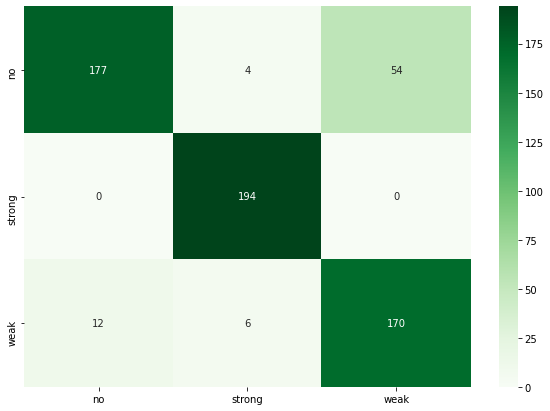

In [ ]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

###Further finetune the model on the 1100 labelled samples from our dataset, preprocessed

In [ ]:
#retrieve preprocessed data split

train_path = "drive/MyDrive/empathy_classifier_data/my_train_prep.txt"
test_path = "drive/MyDrive/empathy_classifier_data/my_test_prep.txt"
val_path = "drive/MyDrive/empathy_classifier_data/my_val_prep.txt"


In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_train_prep", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_val_prep", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

##Train the T5 model

In [ ]:
#load the tokenizer for this model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'my_val_prep', 512)

In [ ]:
#show a sample
data = dataset[28]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

do you find yourself trying to control how someone else behaves
no


In [ ]:
#collect rubbish
gc.collect()
torch.cuda.empty_cache()

In [ ]:
args_dict = dict(
    data_dir="", #path for data files
    output_dir="", #path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=12,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0, 
    seed=42,
)

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'num_train_epochs':12})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 1, 'eval_batch_size': 1, 'num_train_epochs': 12, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
device = torch.device('cuda:0')

In [ ]:
#load model (uncomment to load)

model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_empathy/T5empathy_finetuned_prep.pt'))
model.to(device)


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmpathyDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#train loop
trainer.fit(model)

##Test set evaluation

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'my_test_prep', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print some predictions
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual label: %s" % targets[i])
    print("predicted label: %s" % dec[i])
    print("=====================================================================\n")

text: thats ok thank you for letting me know do you feel perhaps that someone or something else is
causing your negative feelings

Actual label: strong
predicted label: strong

text: do you often feel that it is your job to save others or that other people expect you to be
that way

Actual label: weak
predicted label: weak

text: thank you from what you have told me i understand that you are feeling do you think this more
or less describes the way youre feeling

Actual label: strong
predicted label: strong

text: do you feel like you have let someone down

Actual label: no
predicted label: no

text: its normal to blame ourselves when something happens that hurts us but if we always do this it
can build up into very angry feelings do you think that you tend to always blame yourself for every
mistake

Actual label: strong
predicted label: strong

text: im sorry about that was this caused by a specific events

Actual label: weak
predicted label: weak

text: are you having difficulties wit

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'my_test_prep', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in labels:
    print(i, 'detected invalid prediction')
    del outputs[i]
    del targets[i]

In [ ]:
#other metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.8214    0.7419    0.7797        31
      strong     0.7674    0.8462    0.8049        39
        weak     0.6500    0.6341    0.6420        41

    accuracy                         0.7387       111
   macro avg     0.7463    0.7407    0.7422       111
weighted avg     0.7391    0.7387    0.7377       111



####Confusion matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

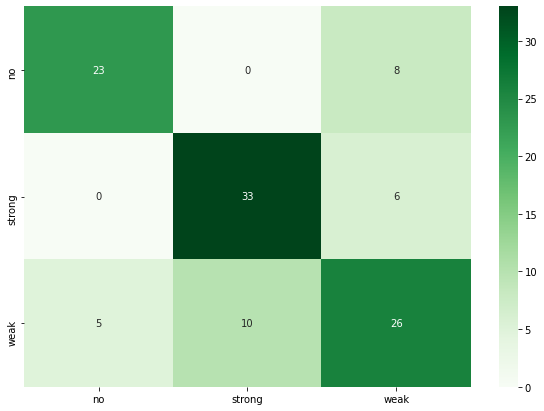

In [ ]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')